In [7]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from textblob import TextBlob
import matplotlib.pyplot as plt
from collections import Counter
from scipy.stats import entropy
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel
from gensim import corpora
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
import logging

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\aravi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\aravi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\aravi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [8]:
# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

class SentimentAnalysis:
    def __init__(self, data):
        if not {'timestamp', 'sender', 'message'}.issubset(data.columns):
            raise ValueError("Input data must contain 'timestamp', 'sender', and 'message' columns.")
        self.data = data.dropna(subset=['message']).reset_index(drop=True)
        self.documents = None
    
    def topic_modeling(self, n_topics=5, max_df=0.95, min_df=2, stop_words='english'):
        '''Perform Topic Modeling using Latent Dirichlet Allocation (LDA)'''
        try:
            vectorizer = CountVectorizer(max_df=max_df, min_df=min_df, stop_words=stop_words)
            doc_term_matrix = vectorizer.fit_transform(self.data['message'])

            # Create the LDA model
            lda_model = LatentDirichletAllocation(n_components=n_topics, random_state=42)
            lda_output = lda_model.fit_transform(doc_term_matrix)

            # Print top words for each topic
            feature_names = vectorizer.get_feature_names_out()
            for topic_idx, topic in enumerate(lda_model.components_):
                top_words = [feature_names[i] for i in topic.argsort()[:-10 - 1:-1]]
                logging.info(f"Topic {topic_idx + 1}: {', '.join(top_words)}")
            
            return lda_model, lda_output
        except Exception as e:
            logging.error(f'Error during topic modeling: {e}')
    
    def preprocess_messages(self):
        '''Preprocess messages: tokenize, remove stopwords, and punctuation.'''
        try:
            stop_words = set(stopwords.words('english'))
            documents = []
            for message in self.data['message']:
                # Tokenize, convert to lowercase, remove stop words and punctuation
                tokens = word_tokenize(message.lower())
                tokens = [word for word in tokens if word not in stop_words and word not in string.punctuation]
                documents.append(tokens)
                
            self.documents = documents
            return documents
        except Exception as e:
            logging.error(f'Error during message preprocessing: {e}')

    def calculate_lda_coherence(self, num_topics_range=range(2, 11), coherence_metric='c_v'):
        '''Calculate coherence scores for LDA models with varying number of topics.'''
        if not self.documents:
            logging.error('Documents are not preprocessed. Run preprocess_messages() first.')
            return
        
        # Create dictionary and corpus
        dictionary = corpora.Dictionary(self.documents)
        corpus = [dictionary.doc2bow(doc) for doc in self.documents]

        # Coherence scores
        coherence_scores = {}
        for num_topics in num_topics_range:
            try:
                # Train LDA model
                lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, random_state=42)

                # Calculate coherence score
                coherence_model = CoherenceModel(model=lda_model, texts=self.documents, dictionary=dictionary, coherence=coherence_metric)
                coherence_scores[num_topics] = coherence_model.get_coherence()
            except Exception as e:
                logging.error(f'Error calculating coherence for {num_topics} topics: {e}')

        # Visualization
        plt.style.use('dark_background')
        plt.Figure(figsize=(10, 6))
        plt.plot(list(coherence_scores.keys()), list(coherence_scores.values()), marker='o', color='#128C7E')
        plt.title('Topic Coherence Scores', fontsize=16, color='#25D366')
        plt.xlabel('Number of Topics')
        plt.ylabel('Coherence Score')
        plt.grid(False)
        plt.tight_layout()
        plt.show()

        return coherence_scores
    
    def sentiment_analysis(self):
        '''Perform Sentiment Analysis on messages'''
        try:
            self.data['sentiment_polarity'] = self.data['message'].apply(lambda x: TextBlob(x).sentiment.polarity)
            self.data['sentiment_category'] = self.data['sentiment_polarity'].apply(
                lambda x: 'positive' if x > 0 else ('negative' if x < 0 else 'neutral')
            )

            # Sentiment distribution
            sentiment_dist = self.data['sentiment_category'].value_counts()

            # Visualization
            plt.style.use('dark_background')
            plt.figure(figsize=(10, 6))
            wedges, texts, autotexts = plt.pie(sentiment_dist, labels=sentiment_dist.index, autopct='%1.1f%%', colors=['#ECE5DD', '#509E2F', '#971B2F'], )
            plt.title('Sentiment Distribution', fontsize=16, color='#25D366')

            # Change pct color 
            for autotext in autotexts:
                autotext.set_color('black')

            plt.tight_layout()
            plt.show()

            return self.data[['message', 'sentiment_polarity', 'sentiment_category']]
        except Exception as e:
            logging.error(f'Error during sentiment analysis: {e}')
    
    def analyze_response_time(self):
        '''Analyze response times between messages from different senders.'''
        try:
            self.data['timestamp'] = pd.to_datetime(self.data['timestamp'], errors='coerce')
            self.data = self.data.dropna(subset=['timestamp']).sort_values('timestamp')
            self.data['prev_sender'] = self.data['sender'].shift()
            self.data['response_time'] = (self.data['timestamp'] - self.data['timestamp'].shift()).dt.total_seconds() / 60

            response_times = self.data[self.data['sender'] != self.data['prev_sender']]['response_time'].dropna()

            logging.info(
                f'\n Response Time Statistics: \n Mean: {response_times.mean():.2f} min \n Median: {response_times.median():.2f} min \n Max: {response_times.max():.2f} min'
            )

            return response_times.describe()
        except Exception as e:
            logging.error(f'Error during response time analysis: {e}')
    
    def calculate_linguistic_complexity(self):
        '''Calculate linguistic complexity metrics for messages.'''
        try:
            words = ' '.join(self.data['message']).lower().split()
            unique_words = set(words)
            type_token_ratio = len(unique_words) / len(words) if words else 0 # Calculates the diversity of vocabulary in a text

            # Word entropy
            word_freq = Counter(words)
            word_entropy = entropy(list(word_freq.values())) if words else 0 # Measures the linguistic complexity that quantifies unpredictability or randomness of words

            # Average sentence length
            avg_sentence_length = np.mean([len(sentence.split()) for sentence in self.data['message']]) if words else 0

            logging.info(
                f'\n Linguistic Complexity Metrics: \n Type-Token Ratio (TTR): {type_token_ratio:.2f} \n Word Entropy: {word_entropy:.2f} \n Average Sentence Length: {avg_sentence_length:.2f}'
            )
            
            return {
                'Type-Token Ratio (TTR)': type_token_ratio,
                'Word Entropy': word_entropy,
                'Average Sentence Length': avg_sentence_length
            }
        except Exception as e:
            logging.error(f'Error during linguistic complexity calculation: {e}')
    
    def export_to_csv(self, output_path):
        '''
        Export the updated data to a CSV file.
        output_path: Path to save the CSV file.
        '''
        self.data.to_csv(output_path, index=False)
        print(f'Updated data exported successfully to {output_path}')

2025-01-27 16:26:51,148 - INFO - Topic 1: dhaan, la, dhan, illa, oru, idhu, ok, ila, ipo, indha
2025-01-27 16:26:51,149 - INFO - Topic 2: nu, iruku, nee, dhan, கள, ena, arvi, 919943937111, day, maari
2025-01-27 16:26:51,150 - INFO - Topic 3: aditi, aija, kutty, enna, naa, dhan, adhu, la, sooper, ku
2025-01-27 16:26:51,150 - INFO - Topic 4: ah, la, mom, ku, nu, super, naa, uh, iruku, vera
2025-01-27 16:26:51,151 - INFO - Topic 5: https, com, www, reel, instagram, youtu, facebook, aamaaa, igshid, kiru
2025-01-27 16:26:51,455 - INFO - adding document #0 to Dictionary<0 unique tokens: []>
2025-01-27 16:26:51,497 - INFO - adding document #10000 to Dictionary<12167 unique tokens: ['..', '...', 'ages', 'csk', 'dheiva']...>
2025-01-27 16:26:51,505 - INFO - built Dictionary<13998 unique tokens: ['..', '...', 'ages', 'csk', 'dheiva']...> from 11860 documents (total 52286 corpus positions)
2025-01-27 16:26:51,506 - INFO - Dictionary lifecycle event {'msg': "built Dictionary<13998 unique tokens: [

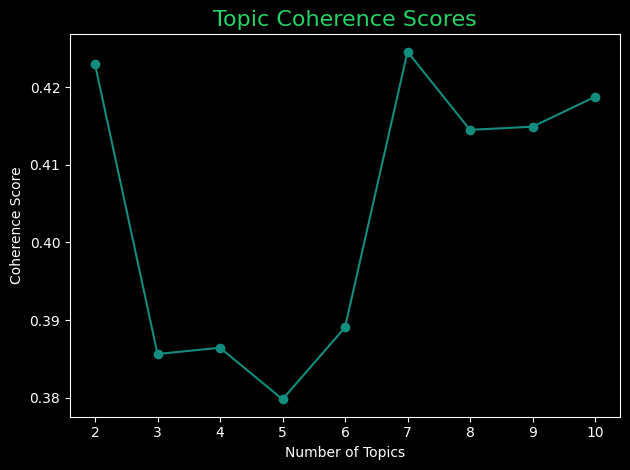

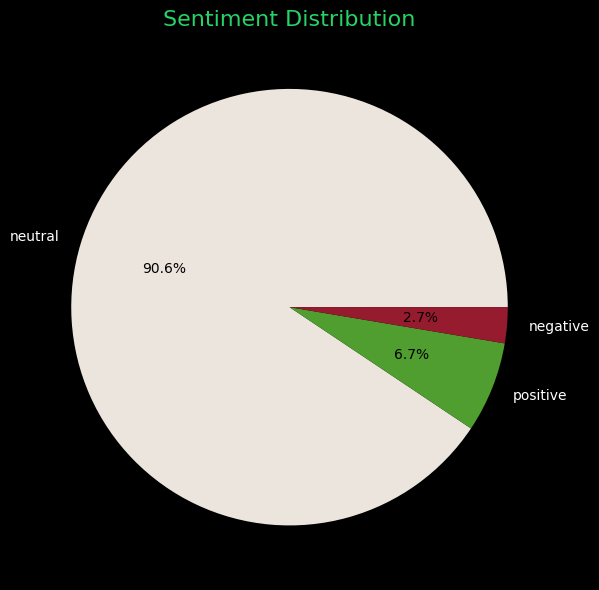

2025-01-27 16:28:50,392 - INFO - 
 Response Time Statistics: 
 Mean: 200.01 min 
 Median: 8.00 min 
 Max: 8578.00 min
2025-01-27 16:28:50,414 - INFO - 
 Linguistic Complexity Metrics: 
 Type-Token Ratio (TTR): 0.34 
 Word Entropy: 8.48 
 Average Sentence Length: 4.20


Updated data exported successfully to Whatsapp_Chat.csv


In [9]:
# Load the data
data = pd.read_csv('Whatsapp_Chat.csv')

# Intialize the class with the data
sentiment = SentimentAnalysis(data)

# Topic modeling
lda_model, lda_output = sentiment.topic_modeling(n_topics=5)

# Preprocess messages
preprocessed_docs = sentiment.preprocess_messages()

# LDA coherence scores
coherence_scores = sentiment.calculate_lda_coherence()

# Sentiment Analysis
sentiment_results = sentiment.sentiment_analysis()

# Response time analysis
response_stats = sentiment.analyze_response_time()

# Linguistic complexity metrics
complexity_metrics = sentiment.calculate_linguistic_complexity()

# Export updated data to CSV
sentiment.export_to_csv('Whatsapp_Chat.csv')